## Real and Imaginary parts of k-space as an input of NN

In [1]:
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
from skimage.measure import compare_ssim, compare_psnr

from torch.utils import data as torch_data

In [2]:
PATH_TO_SOURCE_TRAIN = 'dl_bio/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'dl_bio/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'dl_bio/ax_t2_source_test'
RANDOM_STATE = 42

In [3]:
def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)

In [4]:
def calculate_spec(fft):
    spectrum = 20*np.log(np.abs(fft) + 1e-9)
    return spectrum

In [296]:
class MRIDataSampler(torch_data.Dataset):
    def __init__(self, path_to_data, seed=None):
        super().__init__()

        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]

    def __len__(self):
        return len(self.images)

    def sample_slice(self, slice):
        slice_fft = np.fft.fft2(slice)
        slice_kspace = np.fft.fftshift(slice_fft)
        fft_real = np.real(slice_kspace)
        fft_imag = np.imag(slice_kspace)
        tensor = np.stack((fft_real, fft_imag), axis = 1)[0]
#         fft_real_tens = tensor[0, :, :]
#         fft_imag_tens = tensor[1, :, :]
        
        return tensor

    def __getitem__(self, idx):
        
        slice = npy_load(self.images[idx])
        slice_sampled = self.sample_slice(slice)
        

        return self.images[idx], slice_sampled

In [297]:
i = np.random.randint(0, len(os.listdir(PATH_TO_SOURCE_VAL)))

(2, 320, 320)
dl_bio/ax_t2_source_val\476902731320_8.npy


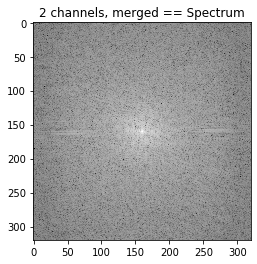

In [299]:
train_loader = MRIDataSampler(PATH_TO_SOURCE_VAL, seed=RANDOM_STATE)

name, tensor = train_loader.__getitem__(i)
print(tensor.shape)
spec_2ch_tensor =  calculate_spec(tensor[0])
plt.imshow(spec_2ch_tensor, cmap='gray')
plt.title("2 channels, merged == Spectrum", fontsize =12)
print(name)
plt.show()

C:\Users\Margarita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


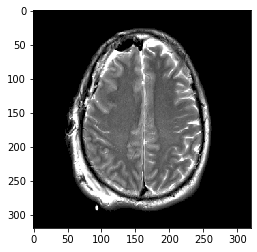

In [300]:
t = tensor[0] + 1j * tensor[1]
a = np.fft.ifftshift(t)
s = np.fft.ifft2(a)
s = np.array(s, dtype=float)
plt.imshow(s, cmap='gray')

In [201]:
samples_val = os.listdir(PATH_TO_SOURCE_VAL)
samples_val = [os.path.join(PATH_TO_SOURCE_VAL, p) for p in samples_train]
len(samples_val)

14697